# Delineation (Homebrew DEM)

This method really refers to making your own DEM form a contour map then running python scripts to help identify the boundary.

## Example using Florida Training Watershed

Consider the image below, the point of interest is the blue dot.

![](Florida-Training-Watershed.png)

To find the watershed boundary we can digitize the contours, then use a particle tracking algorithm to find points that drain to the blue dot (or close to the blue dot).

Digitize using [G3DATA](https://alternativeto.net/software/g3data/?platform=windows) or something similar to get XY coordinates of the level sets (contours)  Here is the graphic loaded into G3DATA.

![](g3data-florida-training.png)

Next digitize some of the contours (should do all, but that takes too much time to illustrate).

Here is the manual digitize of the 160 contour line:

![](g3data-florida-training-160.png)

### Collect the Data

A small sample of the exported files is

```
X-Easting	Y-Northing	Z-Elevation
662.0918525	3772.927975	90.0
567.9050539	3733.188964	90.0
480.271114	3645.751891	90.0
541.243637	3540.990522	90.0
540.3155497	3376.072222	90.0
581.2638862	3228.225103	90.0
... many rows ...
492.1393818	2997.131367	100.0
364.2602019	3030.964367	100.0
225.1033552	3091.093174	100.0
75.79379588	3134.994516	100.0
-96.07109711	3231.487471	100.0
-238.8277976	3227.69075	100.0
-353.7418792	3171.443035	100.0
-458.0813904	3115.476559	100.0
2181.961358	1121.860674	150.0
2059.510082	1150.518885	150.0
2066.70979	1278.369941	150.0
... many rows ...
```


Next check the contours against original image:

Indices of black box on overlay below:
xyz lower left corner  -211.11642335384613 -350.0720763769231 nan
xyz lower right corner 4234.252983476923 -350.0720763769231 nan
xyz upper left corner  -211.11642335384613 3800.749680638461 145.10477989455964
xyz upper right corner  4234.252983476923 3800.749680638461 nan


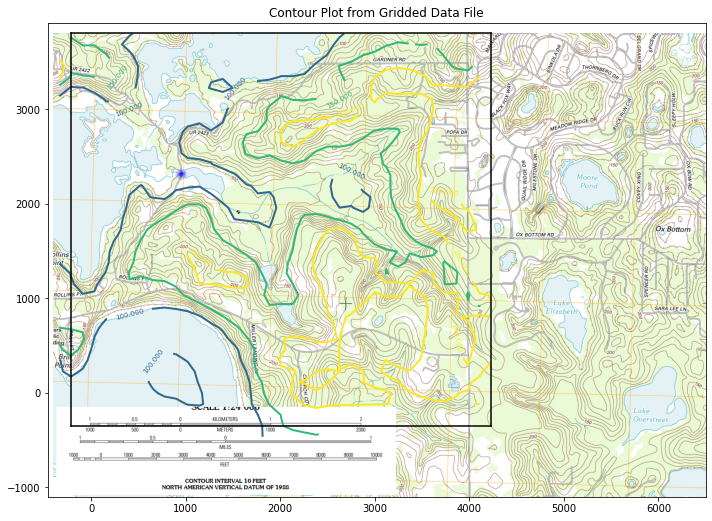

In [130]:
# CCMR from ENGR-1330:
# http://54.243.252.9/engr-1330-webroot/8-Labs/Lab07/Lab07.html
# https://clouds.eos.ubc.ca/~phil/docs/problem_solving/06-Plotting-with-Matplotlib/06.14-Contour-Plots.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
# https://stackoverflow.com/questions/3242382/interpolation-over-an-irregular-grid
# https://stackoverflow.com/questions/33919875/interpolate-irregular-3d-data-from-a-xyz-file-to-a-regular-grid
import pandas
my_xyz = pandas.read_csv('Florida-Training-Watershed-LevelSets.dat',sep='\t') # read an ascii file already prepared, delimiter is tabs
#my_xyz = pandas.read_csv('XYZSomewhereUSA.txt',sep=' ') # read an ascii file already prepared, delimiter is tabs
my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
#print(my_xyz) #examine the dataframe
import numpy 
import matplotlib.pyplot
from scipy.interpolate import griddata
# extract lists from the dataframe
coord_x = my_xyz['X-Easting'].values.tolist()
coord_y = my_xyz['Y-Northing'].values.tolist()
coord_z = my_xyz['Z-Elevation'].values.tolist()
coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
lon = numpy.linspace(min(coord_x), max(coord_x), 40)
lat = numpy.linspace(min(coord_y), max(coord_y), 40)
X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use cubic spline interpolation (other choices are nearest and linear)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic', fill_value = 'nan')
# Build the map
print("Indices of black box on overlay below:")
ixl = 2
ixh = 38
iyl = 2
iyh = 38
#print("x",X)
#print("y",Y)
#print("z",Z)
print("xyz lower left corner ",X[iyl][ixl],Y[iyl][ixl],Z[iyl][ixl])
print("xyz lower right corner",X[iyl][ixh],Y[iyl][ixh],Z[iyl][ixh])
print("xyz upper left corner ",X[iyh][ixl],Y[iyh][ixl],Z[iyh][ixl])
print("xyz upper right corner ",X[iyh][ixh],Y[iyh][ixh],Z[iyh][ixh])
xxl = X[iyl][ixl]
xxh = X[iyh][ixh]
yyl = Y[iyl][ixl]
yyh = Y[iyh][ixh]
flag=True
if flag:
    matplotlib.pyplot.rcParams["figure.figsize"] = [10.00, 8.00]
    matplotlib.pyplot.rcParams["figure.autolayout"] = True
    im = matplotlib.pyplot.imread("Florida-Training-Watershed.png") # base image
fig, ax = matplotlib.pyplot.subplots()
if flag: 
    im = ax.imshow(im, extent=[-400, 6500, -1100, 3800])# sets X and Y plot window of basemap
#fig.set_size_inches(14, 7)
levels=[50,100,150,200]
CS = ax.contour(X, Y, Z, levels, linewidths=2)
ax.clabel(CS, inline=2, fontsize=7)
ax.set_title('Contour Plot from Gridded Data File')
#ax.set_xlim([0,1000])
#ax.set_ylim([0,800])
ax.plot([xxl,xxh],[yyl,yyl],color="black")
ax.plot([xxl,xxh],[yyh,yyh],color="black")
ax.plot([xxl,xxl],[yyl,yyh],color="black")
ax.plot([xxh,xxh],[yyl,yyh],color="black");

Not terrible, good enough to illustrate next step - we do need to find the blue dot in the arbitrary coordinates - looks to be at 900,2300 or close.

In [160]:
Conductivity = 0.5 # feet/day
Porosity = 1.0 # voids/bulk
nrows = iyh - iyl
ncols = ixh - ixl
#Zero vectors for the velocity fields
U = [[0 for j in range(ncols)] for i in range(nrows)]
V = [[0 for j in range(ncols)] for i in range(nrows)]
#Zero vectors for realinged mesh grid
XG = [[0 for j in range(ncols)] for i in range(nrows)]
YG = [[0 for j in range(ncols)] for i in range(nrows)]
for j in range(ncols):
    for i in range(nrows): #range(nrows)
        U[i][j] = -1.0*(Conductivity/Porosity)*(Z[iyl+i][ixl+j]-Z[iyl+i][ixl+j-1])/(X[iyl+i][ixl+j]-X[iyl+i][ixl+j-1]) #- K dh/dx
        V[i][j] = -1.0*(Conductivity/Porosity)*(Z[iyl+i][ixl+j]-Z[iyl+i-1][ixl+j])/(Y[iyl+i][ixl+j]-Y[iyl+i-1][ixl+j]) #- K dh/dy
        XG[i][j] = X[iyl+i][ixl+j]
        YG[i][j] = Y[iyl+i][ixl+j]

In [161]:
# convert to numpy arrays
UU = numpy.asarray(U)
VV = numpy.asarray(V)
XX = numpy.asarray(XG)
YY = numpy.asarray(YG)

UU[30][30]

-0.010984096454629564

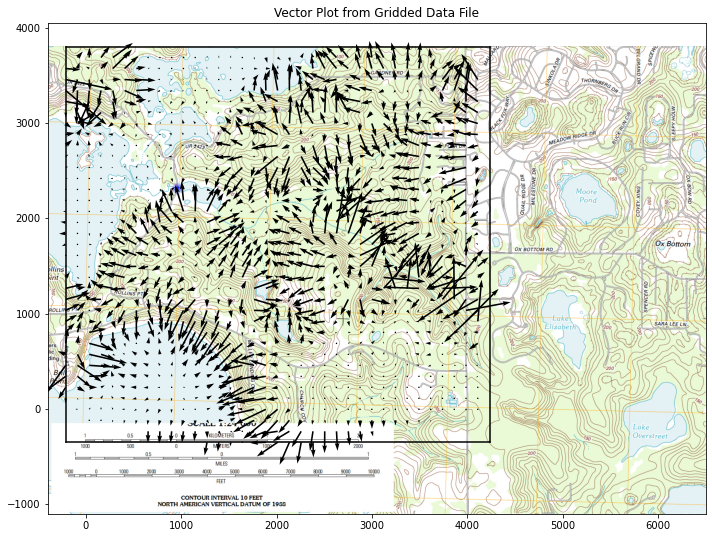

In [162]:
if flag:
    matplotlib.pyplot.rcParams["figure.figsize"] = [10.00, 8.00]
    matplotlib.pyplot.rcParams["figure.autolayout"] = True
    im = matplotlib.pyplot.imread("Florida-Training-Watershed.png") # base image
fig, ax = matplotlib.pyplot.subplots()
if flag: 
    im = ax.imshow(im, extent=[-400, 6500, -1100, 3800])# sets X and Y plot window of basemap
#fig.set_size_inches(14, 7)
levels=[50,100,150,200]
CS = ax.quiver(XX[::1, ::1], YY[::1, ::1], UU[::1, ::1], VV[::1, ::1], units='width')
#ax.clabel(CS, inline=2, fontsize=12)
ax.set_title('Vector Plot from Gridded Data File')
#ax.set_xlim([0,1000])
#ax.set_ylim([0,800]);
ax.plot([xxl,xxh],[yyl,yyl],color="black")
ax.plot([xxl,xxh],[yyh,yyh],color="black")
ax.plot([xxl,xxl],[yyl,yyh],color="black")
ax.plot([xxh,xxh],[yyl,yyh],color="black");

This gives a useful clue to watershed boundary, the vector plot shows water flow pathways.  we can also try a streamline plot.

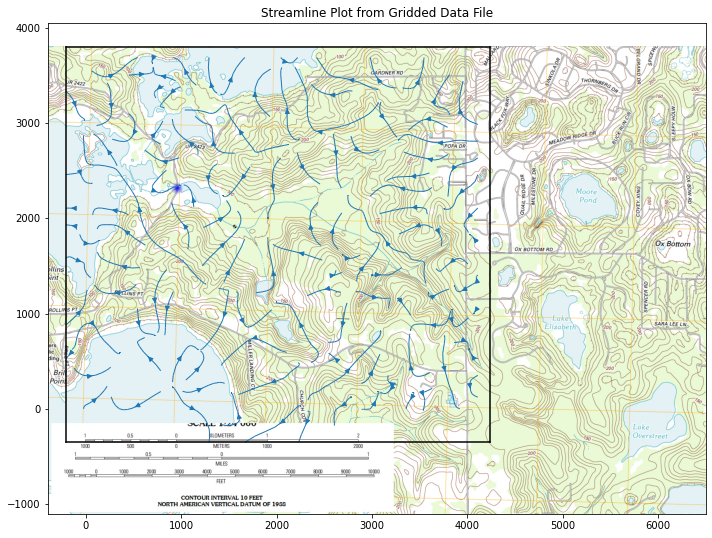

In [163]:
if flag:
    matplotlib.pyplot.rcParams["figure.figsize"] = [10.00, 8.00]
    matplotlib.pyplot.rcParams["figure.autolayout"] = True
    im = matplotlib.pyplot.imread("Florida-Training-Watershed.png") # base image
fig, ax = matplotlib.pyplot.subplots()
if flag: 
    im = ax.imshow(im, extent=[-400, 6500, -1100, 3800])# sets X and Y plot window of basemap
#fig.set_size_inches(14, 7)
levels=[50,100,150,200]
CS = ax.streamplot(XX, YY, UU, VV,  density=0.8, linewidth=1, color=None, arrowsize=1)
#ax.clabel(CS, inline=2, fontsize=12)
ax.set_title('Streamline Plot from Gridded Data File')
#ax.set_xlim([0,1000])
#ax.set_ylim([0,800]);
ax.plot([xxl,xxh],[yyl,yyl],color="black")
ax.plot([xxl,xxh],[yyh,yyh],color="black")
ax.plot([xxl,xxl],[yyl,yyh],color="black")
ax.plot([xxh,xxh],[yyl,yyh],color="black");

Finally can consider particle tracks to find boundary

In [168]:
# U array x-velocity at XG,YG
# V array y-velocity at XG,YG
# XG array X-value of cell center
# YG array Y-value of cell center
# XP X-value of particle position 
# YP Y-value of particle position
# UP x-velocity of particle 
# VP y-velocity of particle
# TX x-component particle trajectory
# TY y-component particle trajectory

import math
verbose=False
terse=False
deltaT = 2000
etime = 0
numTime = 500
XP = []
YP = []
UP = []
VP = []
TX = [] #trajectory vector
TY = []
np = 1 # Total particles 
XP.append(1500)
YP.append(1500)
UP.append(0)
VP.append(0)
ip=np-1 
print("                   Initial Particle Position",round(XP[ip],2),round(YP[ip],2),round(UP[ip],2),round(VP[ip],2),round(etime,2))

# move particles this time step
for it in range(numTime):
    for ip in range(np):
    # Build Particle Distance Table
        dist = []
        index = []
        count = 0
        for j in range(ncols):
            for i in range(nrows): #range(nrows)
                dist.append(math.sqrt((XX[i][j]-XP[ip])**2 + (YY[i][j]-YP[ip])**2))
                index.append([count,i,j]) # use to find i,j for a given index
                count = count +1
    # find closest cell
        for i in range(count):
            if dist[i] <= min(dist):
                #print(index[i],dist[i])
                ixx=index[i][1]
                jyy=index[i][2]
    # use nearest cell assignment - aka simple scheme
                UP[ip] = UU[ixx][jyy]
                VP[ip] = VV[ixx][jyy]
                if verbose: print("Particle Position and Velocities Before Move",round(XP[ip],2),round(YP[ip],2),round(UP[ip],2),round(VP[ip],2),round(etime,2))
                break #exits the loop - we stop at the first nearest cell encountered
    # move the particle
        XP[ip]=XP[ip]+UP[ip]*deltaT
        YP[ip]=YP[ip]+VP[ip]*deltaT
        etime=etime+deltaT
        if terse: print(" Particle Position and Velocities After Move",round(XP[ip],2),round(YP[ip],2),round(UP[ip],2),round(VP[ip],2),round(etime,2))
        TX.append([ip,XP[ip],etime])
        TY.append([ip,YP[ip],etime])

                   Initial Particle Position 1500 1500 0 0 0


''

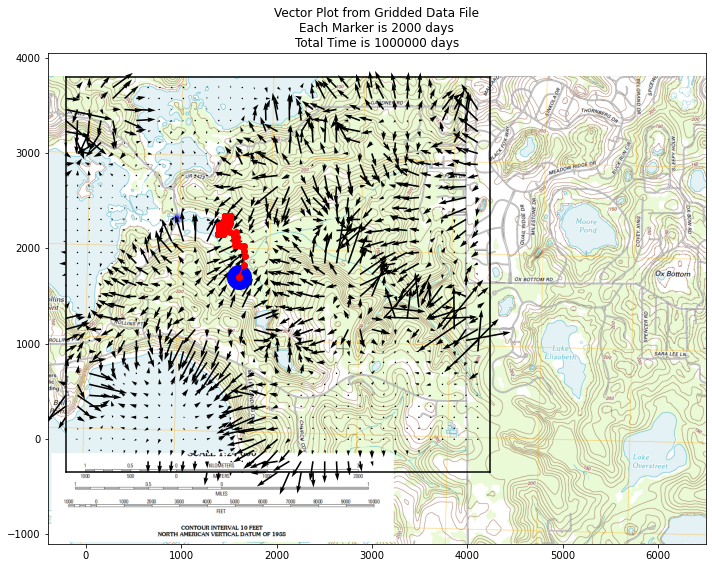

In [169]:
if flag:
    matplotlib.pyplot.rcParams["figure.figsize"] = [10.00, 8.00]
    matplotlib.pyplot.rcParams["figure.autolayout"] = True
    im = matplotlib.pyplot.imread("Florida-Training-Watershed.png") # base image
fig, ax = matplotlib.pyplot.subplots()
if flag: 
    im = ax.imshow(im, extent=[-400, 6500, -1100, 3800])# sets X and Y plot window of basemap
#fig.set_size_inches(14, 7)
levels=[50,100,150,200]
CS = ax.quiver(XX[::1, ::1], YY[::1, ::1], UU[::1, ::1], VV[::1, ::1], units='width')
#ax.clabel(CS, inline=2, fontsize=12)
ax.set_title('Vector Plot from Gridded Data File\n' +\
            'Each Marker is ' + str(deltaT) + ' days\n' +\
            'Total Time is ' + str(etime) + ' days')
#ax.set_xlim([0,1000])
#ax.set_ylim([0,800]);
ax.plot([xxl,xxh],[yyl,yyl],color="black")
ax.plot([xxl,xxh],[yyh,yyh],color="black")
ax.plot([xxl,xxl],[yyl,yyh],color="black")
ax.plot([xxh,xxh],[yyl,yyh],color="black")
xtrajectory = [sublist[1] for sublist in TX]
ytrajectory = [sublist[1] for sublist in TY]
ax.plot(xtrajectory[0],ytrajectory[0],marker="o",color="blue",markersize=12)
ax.plot(xtrajectory,ytrajectory,marker="o",color="red")
;